Following the ideas of theorem 3 in Reddi2018 (On the convergence of Adam and Beyond), we will try and achieve suboptimal behavior using variance in the dimensions. We can try quadratics of the form $\alpha x^2 + \beta y^2$ with $\alpha/\beta$ far from 1, i.e., they will be very different.  

In [1]:
from torch import nn, tensor
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
class QuadraticNet2D(nn.Module):
    def __init__(self,a,b):
        super(QuadraticNet2D, self).__init__()
        self.w = nn.Parameter(tensor([5.0,5.0]))
        self.a = a 
        self.b = b

    def forward(self):
        return self.a*self.w[0]**2 + self.b*self.w[1]**2
    
def get_point(model: QuadraticNet2D):
    return model.w[0].detach(),model.w[1].detach()

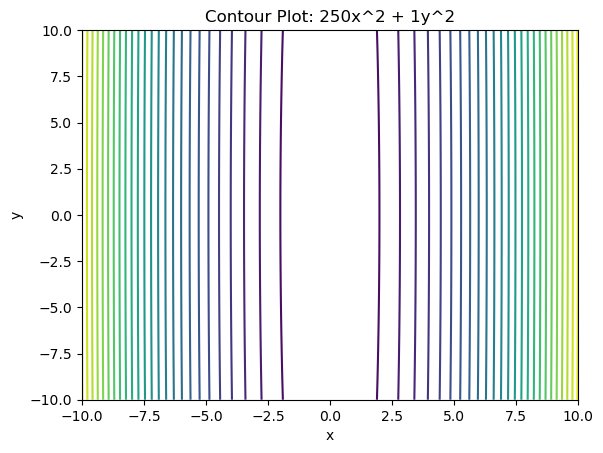

In [3]:
a = 250
b = 1
model1 = QuadraticNet2D(a,b)
model2 = QuadraticNet2D(a,b)
model3 = QuadraticNet2D(a,b)
model4 = QuadraticNet2D(a,b)


beta0 = 0.9
beta1 = 0.99
betas = (beta0,beta1)

# Define the range of x and y values
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Create a meshgrid of x and y values
X, Y = np.meshgrid(x, y)


# Calculate the function values for each point in the meshgrid
Z = a*X**2 + b*Y**2

# Create a contour plot
plt.contour(X, Y, Z,levels=30)

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Contour Plot: {a}x^2 + {b}y^2'.format(b))

# Show the plot
plt.show()



In [4]:
assert get_point(model1) == get_point(model2) == get_point(model3) == get_point(model4)
first_point = get_point(model1) 
adam = optim.Adam(model1.parameters(),betas=betas)
adamW = optim.AdamW(model2.parameters(), betas=betas)
amsgrad = optim.Adam(model3.parameters(),betas=betas,amsgrad=True)
sgd = optim.SGD(model4.parameters()) 
num_epochs = 1000
point_array = np.zeros((4,num_epochs+1,2))
point_array[:,0] = first_point

In [5]:
for epoch in range(num_epochs):
    adam.zero_grad()
    adamW.zero_grad()
    amsgrad.zero_grad()
    sgd.zero_grad()

    loss1,loss2,loss3,loss4 = model1.forward(), model2.forward(), model3.forward(), model4.forward()
    loss1.backward()
    loss2.backward()
    loss3.backward()
    loss4.backward()

    adam.step()
    adamW.step()
    amsgrad.step()
    sgd.step()
    
    point_array[0,epoch+1] = get_point(model1)
    point_array[1,epoch+1] = get_point(model2)
    point_array[2,epoch+1] = get_point(model3)
    point_array[3,epoch+1] = get_point(model4)

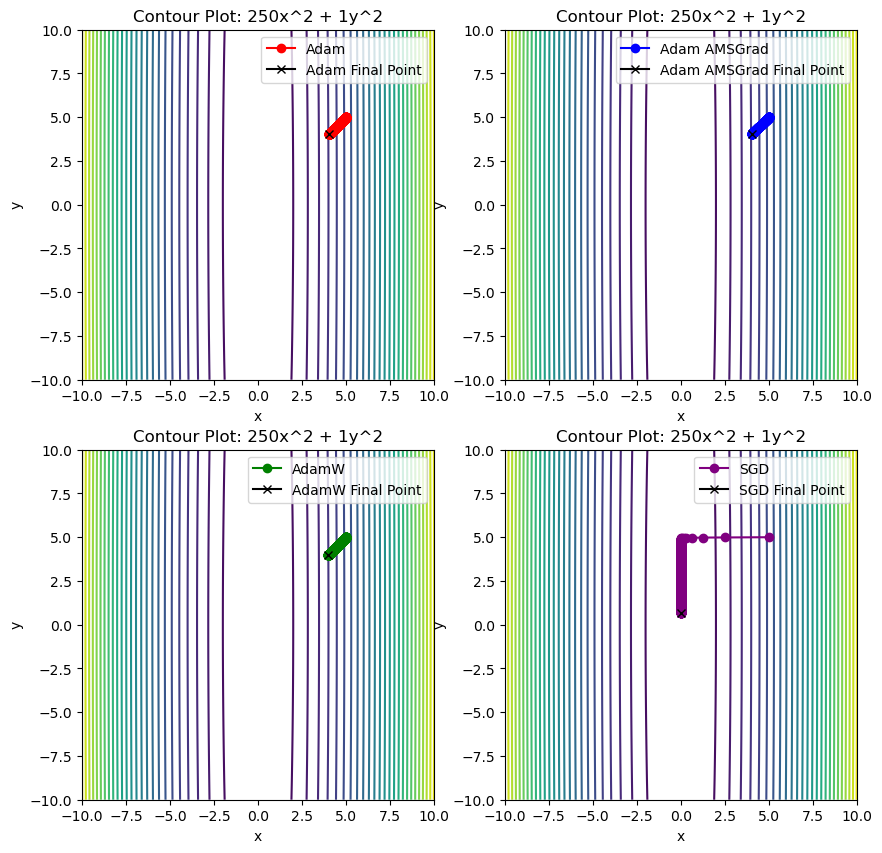

In [6]:
fig, axs = plt.subplots(2,2,figsize=(10,10))


# Create a contour plot


color_list = ['red','green','blue','purple']
optimizer_list = ['Adam','AdamW','Adam AMSGrad','SGD']

# Add point array entries to the contour plot
for i in range(point_array.shape[0]):
    pos1,pos2 = i % 2, i // 2
    axs[pos1,pos2].contour(X, Y, Z, levels=30)
    axs[pos1,pos2].plot(point_array[i,:,0], point_array[i,:,1], marker='o',color=color_list[i],label=f'{optimizer_list[i]}')
    axs[pos1,pos2].plot(point_array[i,-1,0], point_array[i,-1,1], marker='x',color='black',label=f'{optimizer_list[i]} Final Point')
    axs[pos1,pos2].set_xlabel('x')
    axs[pos1,pos2].set_ylabel('y')
    axs[pos1,pos2].set_title(f'Contour Plot: {a}x^2 + {b}y^2')
    axs[pos1,pos2].legend()


# Show the plot
plt.legend()
plt.savefig('Optimizer_behavior_2d.png')


In [7]:
print(f'Adam Final Point: {point_array[0,-1]}')
#print('norm of Adam path:',np.linalg.norm(point_array[0],axis=1))
print(f'AdamW Final Point: {point_array[1,-1]}')
#print('norm of AdamW path:',np.linalg.norm(point_array[1],axis=1))
print(f'Adam AMSGrad Final Point: {point_array[2,-1]}')
#print('norm of Adam AMSGrad path:',np.linalg.norm(point_array[2],axis=1))
print(f'SGD Final Point: {point_array[3,-1]}')
#print('norm of SGD path:',np.linalg.norm(point_array[3],axis=1))

Adam Final Point: [4.01627779 4.01627731]
AdamW Final Point: [3.9722054 3.9722054]
Adam AMSGrad Final Point: [4.04928589 4.04928589]
SGD Final Point: [0.         0.67532188]


In [8]:
print('norm infinity differences\n')
print('Adam - AdamW:', np.linalg.norm(point_array[0]-point_array[1],ord=np.inf))
print('Adam - Adam AMSGrad:', np.linalg.norm(point_array[0]-point_array[2],ord=np.inf))
print('Adam - SGD:', np.linalg.norm(point_array[0]-point_array[3],ord=np.inf))

print('Matrix of differences\n')
diff_matrix = np.zeros((4,4))
for i in range(4):
    for j in range(i,4):
        diff_matrix[i,j] = np.linalg.norm(point_array[i]-point_array[j],ord=np.inf)

print(diff_matrix)

norm infinity differences

Adam - AdamW: 0.08814430236816406
Adam - Adam AMSGrad: 0.06601667404174805
Adam - SGD: 7.41665917634964
Matrix of differences

[[0.         0.0881443  0.06601667 7.41665918]
 [0.         0.         0.15416098 7.34402549]
 [0.         0.         0.         7.4515866 ]
 [0.         0.         0.         0.        ]]


In [9]:
print('distance covered by each optimizer\n')
#final point - initial point norm 2 
print('Adam:',np.linalg.norm(point_array[0,-1]-point_array[0,0]))
print('AdamW:',np.linalg.norm(point_array[1,-1]-point_array[1,0]))
print('Adam AMSGrad:',np.linalg.norm(point_array[2,-1]-point_array[2,0]))
print('SGD:',np.linalg.norm(point_array[3,-1]-point_array[3,0]))

distance covered by each optimizer

Adam: 1.3911936280660617
AdamW: 1.4535210619935073
Adam AMSGrad: 1.344512790179719
SGD: 6.610812421142451


Note AdamW covers more distance, although this may be due to decaying nature naturally dragging the point to the origin. We can estimate the effect of this decay via $$(1-\gamma \lambda)^n,$$ where $\gamma$ is the learning rate, $\lambda$ is the weight decay, and $n$ is the number of epochs. In our case, we have default parameters $\gamma= 0.001,\lambda=0.01$ and set $n=1000$. This quantity comes out to be $.9900$ (four significant figures), meaning we decay approximately $1\%\sim 0.07=.01*5\sqrt{2}$ in norm. This is an upper bound because it decays less at each step (as it gets closer to 0), but it does explain the difference.  